# Setup and Imports

- **TensorFlow**: Imported for building deep learning models using its high-level Keras API (`tensorflow.keras`).
- **Numpy**: Used for numerical operations, array handling, and setting random seeds for reproducibility.
- **Pandas**: Provides data structures like DataFrames, used for data manipulation and analysis.
- **Scikit-learn**: Specifically imported for `train_test_split` to split the dataset and `StandardScaler` for feature normalization.
- **JSON**: Imported to handle JSON file operations for reading data.

- **Random Seed**: Set seeds for both NumPy and TensorFlow to ensure reproducibility of results across runs.


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import json


# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# Flatten JSON

1. **Function Purpose**: The `flatten_json` function recursively flattens nested JSON objects into a flat dictionary, combining keys at different levels with a separator (`_` by default).

2. **Parameters**:
   - `nested_json`: Input JSON object (which can contain nested dictionaries or lists).
   - `parent_key`: Keeps track of the key hierarchy as the function moves through the nested JSON.
   - `sep`: Separator used to combine keys (default is an underscore `_`).

3. **Recursive Handling**: 
   - If the value is a dictionary, it recursively calls itself to flatten the sub-dictionary.
   - If the value is a list, it iterates over each element, and if it's a dictionary, it also flattens the dictionary.

4. **Output**: Returns a flattened dictionary where each key represents the original hierarchical structure, joined by the specified separator.

5. **Edge Handling**: Non-dictionary and non-list values are directly added to the result without recursion.


In [16]:
# Code: Flatten JSON
def flatten_json(nested_json, parent_key='', sep='_'):
    items = []
    for key, value in nested_json.items():
        new_key = f"{parent_key}{sep}{key}" if parent_key else key
        if isinstance(value, dict):
            items.extend(flatten_json(value, new_key, sep=sep).items())
        elif isinstance(value, list):
            for i, sub_item in enumerate(value):
                if isinstance(sub_item, dict):
                    items.extend(flatten_json(sub_item, f"{new_key}_{i}", sep=sep).items())
                else:
                    items.append((f"{new_key}_{i}", sub_item))
        else:
            items.append((new_key, value))
    return dict(items)


# DataLoader Class

1. **Class Purpose**: The `DataLoader` class is designed to load and preprocess JSON data, specifically flattening it and converting it into a pandas DataFrame.

2. **Attributes**:
   - `file_path`: The file path of the JSON data that needs to be loaded.

3. **Methods**:
   - `__init__(self, file_path)`: Initializes the `DataLoader` object with the path to the JSON file.
   - `load_data(self)`: 
     - Opens and reads the JSON file.
     - Uses the `flatten_json` function to flatten each JSON object.
     - Converts the flattened data into a pandas DataFrame for easier data handling.

4. **Output**: Returns a pandas DataFrame where each row represents a flattened JSON object from the file.

5. **Automatic JSON Flattening**: Each nested JSON object is automatically flattened using the `flatten_json` function, making it easier to process the data for further analysis.


In [17]:
class DataLoader:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        with open(self.file_path, 'r') as f:
            data = json.load(f)
        # Automatically flatten the loaded JSON data
        flattened_data = [flatten_json(item) for item in data]
        return pd.DataFrame(flattened_data)


# DataPreprocessor Class

1. **Class Purpose**: The `DataPreprocessor` class is designed to preprocess data for machine learning models, handling tasks like ID encoding, feature engineering, and normalization.

2. **Attributes**:
   - `scaler`: An instance of `StandardScaler` to normalize numerical features.

3. **Methods**:
   - `__init__(self)`: Initializes the preprocessor with a scaler.
   - `preprocess(self, df)`:
     - Encodes `player_id` and `game_id` as integer indices.
     - Creates a new interaction feature by summing `playtime_online` and `playtime_offline`.
     - One-hot encodes categorical fields (`genre`, `medium`, `platform`).
     - Flattens JSON-like columns (e.g., `playtime`) and expands comma-separated genres.
     - Converts date fields (`last_played`, `last_login`, `first_played`) to ordinal values.
     - Normalizes numerical and one-hot-encoded features using the scaler.
   - `normalize_numerical_features(self, df, numerical_features)`:
     - Fills missing values in numerical columns with the mean.
     - Applies normalization to selected features.

4. **Output**: Returns the preprocessed DataFrame and the unique counts of `player_id` and `game_id`.

5. **Feature Engineering**: The class generates interaction features, handles categorical encoding, processes date fields, and normalizes numerical features for model readiness.



In [18]:
class DataPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()

    def preprocess(self, df):
        player_ids = df['player_id'].unique().tolist()
        game_ids = df['game_id'].unique().tolist()

        player_id_to_index = {x: i for i, x in enumerate(player_ids)}
        game_id_to_index = {x: i for i, x in enumerate(game_ids)}

        df['player_id'] = df['player_id'].map(player_id_to_index)
        df['game_id'] = df['game_id'].map(game_id_to_index)

        df['interaction'] = df[['playtime_online', 'playtime_offline']].sum(axis=1)

        categorical_fields = ['genre', 'medium', 'platform']
        for field in categorical_fields:
            if field in df.columns:
                df = pd.concat([df, pd.get_dummies(df[field], prefix=field)], axis=1)
                df.drop(columns=[field], inplace=True)

        if 'genre' in df.columns:
            genre_dummies = df['genre'].str.get_dummies(sep=',')
            df = pd.concat([df, genre_dummies], axis=1)
            df.drop(columns=['genre'], inplace=True)

        if 'playtime' in df.columns:
            playtime_flat = pd.json_normalize(df['playtime'])
            playtime_flat.columns = [f"playtime_{col}" for col in playtime_flat.columns]
            df = pd.concat([df, playtime_flat], axis=1)
            df.drop(columns=['playtime'], inplace=True)

        date_fields = ['last_played', 'last_login', 'first_played']
        for date_column in date_fields:
            if date_column in df.columns:
                df[date_column] = pd.to_datetime(df[date_column], errors='coerce').map(pd.Timestamp.toordinal)

        all_columns = df.columns.tolist()
        numerical_columns = [col for col in all_columns if col not in ['interaction'] and not col.startswith('medium_') and not col.startswith('platform_') and not col.startswith('player_id') and not col.startswith('game_id')]
        one_hot_columns = [col for col in all_columns if col.startswith('medium_') or col.startswith('platform_')]

        df = self.normalize_numerical_features(df, numerical_columns + one_hot_columns)

        return df, len(player_ids), len(game_ids)

    def normalize_numerical_features(self, df, numerical_features):
        for feature in numerical_features:
            if df[feature].isna().all():
                df[feature] = 0
            else:
                df[feature] = df[feature].fillna(df[feature].mean())
        
        df[numerical_features] = self.scaler.fit_transform(df[numerical_features])
        return df


# DatasetPreparer Class

1. **Class Purpose**: The `DatasetPreparer` class prepares data for model training and evaluation, handling the data splitting and converting it into TensorFlow datasets.

2. **Attributes**:
   - `batch_size`: The size of batches for training, default is 32.

3. **Methods**:
   - `__init__(self, batch_size=32)`: Initializes the class with a specified batch size.
   - `split_data(self, df, test_size=0.2, random_state=42)`:
     - Splits the data into training and testing sets using `train_test_split` with a given test size and random seed.
   - `create_input_tensors(self, df)`:
     - Extracts input features for players, games, and global attributes from the DataFrame.
     - Returns input tensors for user IDs, game IDs, game-specific features, global features, and interaction labels.
   - `prepare_tf_dataset(self, df)`:
     - Converts the data into a TensorFlow dataset and batches it according to the batch size.
   - `get_train_test_datasets(self, df, test_size=0.2, random_state=42)`:
     - Splits the data into training and test sets and prepares TensorFlow datasets for both.

4. **Output**: Returns TensorFlow datasets for both training and testing, containing player IDs, game IDs, game features, global features, and labels.

5. **Tensor Preparation**: Handles the creation of input tensors for player and game data, including relevant features such as playtime and social interactions, which are batched for efficient model training.


In [19]:
class DatasetPreparer:
    def __init__(self, batch_size=32):
        self.batch_size = batch_size

    def split_data(self, df, test_size=0.2, random_state=42):
        return train_test_split(df, test_size=test_size, random_state=random_state)

    def create_input_tensors(self, df):
        user_input = df['player_id'].values
        game_input = df['game_id'].values

        game_features = df[['playtime_online', 'playtime_offline', 'source_game_rank', 
                            'number_of_sessions', 'achievements', 'social_interactions', 
                            'last_played', 'last_login', 'first_played']].values.astype(np.float32)

        global_features = df[[col for col in df.columns if col.startswith('total_playtime') or
                            col.startswith('game_diversity') or col.startswith('social_interactions_total') or
                            col.startswith('medium_') or col.startswith('platform_')]].values.astype(np.float32)
                            
        labels = df['interaction'].values.astype(np.float32)
        return (user_input, game_input, game_features, global_features), labels

    def prepare_tf_dataset(self, df):
        inputs, labels = self.create_input_tensors(df)
        dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
        return dataset.batch(self.batch_size)

    def get_train_test_datasets(self, df, test_size=0.2, random_state=42):
        train, test = self.split_data(df, test_size=test_size, random_state=random_state)
        train_dataset = self.prepare_tf_dataset(train)
        test_dataset = self.prepare_tf_dataset(test)
        return train_dataset, test_dataset


# VAE Class

1. **Class Purpose**: The `VAE` class defines a Variational Autoencoder model for collaborative filtering, designed to learn latent representations of users and games.

2. **Attributes**:
   - `num_users`: The number of users.
   - `num_games`: The number of games.
   - `embedding_dim`: The dimensionality of the latent space (user and game embeddings).

3. **Components**:
   - **Encoder**:
     - A fully connected layer with 128 units and ReLU activation.
     - Two output layers: 
       - `mu`: Mean of the latent variable.
       - `log_var`: Log variance for reparameterization.
   - **Decoder**:
     - A fully connected layer with 128 units and ReLU activation.
     - `output_layer`: A fully connected layer producing game recommendations using a sigmoid activation to output probabilities.

4. **Methods**:
   - `call(self, user_input)`:
     - **Encoder Pass**: Passes the user input through the encoder, producing mean (`mu`) and log variance (`log_var`) for the latent space.
     - **Reparameterization Trick**: Samples latent vectors (`z`) using the reparameterization trick (`z = mu + ε * exp(0.5 * log_var)`).
     - **Decoder Pass**: Decodes the latent vector (`z`) to reconstruct the original input, predicting game preferences.
   - `vae_loss(self, original, reconstructed, mu, log_var)`:
     - **Reconstruction Loss**: Mean squared error between the original and reconstructed data.
     - **KL Divergence**: Measures the difference between the learned distribution and a unit Gaussian.
     - **Total Loss**: Sum of reconstruction loss and KL divergence to penalize divergence from the prior.

5. **Output**: Returns the reconstructed game preferences, along with `mu` and `log_var` for the latent space.

6. **Loss Function**: The custom loss combines reconstruction error with KL divergence to regularize the latent space for effective learning of user-game interactions.


In [20]:
class VAE(Model):
    def __init__(self, num_users, num_games, embedding_dim):
        super(VAE, self).__init__()
        self.num_users = num_users
        self.num_games = num_games
        self.embedding_dim = embedding_dim

        # Encoder layers
        self.encoder = layers.Dense(128, activation='relu')
        self.mu = layers.Dense(embedding_dim)
        self.log_var = layers.Dense(embedding_dim)

        # Decoder layers
        self.decoder = layers.Dense(128, activation='relu')
        self.output_layer = layers.Dense(num_games, activation='sigmoid')

    def call(self, user_input):
        # Encoder forward pass
        x = self.encoder(user_input)
        mu = self.mu(x)
        log_var = self.log_var(x)

        # Reparameterization trick
        epsilon = tf.random.normal(shape=tf.shape(mu))
        z = mu + tf.exp(0.5 * log_var) * epsilon

        # Decoder forward pass
        x = self.decoder(z)
        reconstructed = self.output_layer(x)

        return reconstructed, mu, log_var

    def vae_loss(self, original, reconstructed, mu, log_var):
        reconstruction_loss = tf.reduce_mean(tf.square(original - reconstructed))
        kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
        return reconstruction_loss + kl_loss

# Matrix Factorization Class

1. **Class Purpose**: The `MatrixFactorization` class implements a matrix factorization model for collaborative filtering, designed to learn user and game embeddings through the use of embedding layers.

2. **Attributes**:
   - `num_users`: Total number of users.
   - `num_games`: Total number of games.
   - `embedding_dim`: Dimensionality of the embedding space for both users and games.

3. **Components**:
   - **User Factors**: 
     - An embedding layer that maps user IDs to dense vectors of size `embedding_dim`.
   - **Game Factors**: 
     - An embedding layer that maps game IDs to dense vectors of size `embedding_dim`.

4. **Methods**:
   - `call(self, user_input, game_input)`:
     - Takes user and game input IDs and retrieves their corresponding embeddings from the embedding layers.
     - Returns two sets of embeddings: `user_embedding` and `game_embedding`.

5. **Output**: The method outputs user and game embeddings that can be used for further processing in recommendation tasks, such as predicting user-game interactions or preferences.


In [21]:
class MatrixFactorization(layers.Layer):
    def __init__(self, num_users, num_games, embedding_dim):
        super(MatrixFactorization, self).__init__()
        self.user_factors = layers.Embedding(input_dim=num_users, output_dim=embedding_dim)
        self.game_factors = layers.Embedding(input_dim=num_games, output_dim=embedding_dim)

    def call(self, user_input, game_input):
        user_embedding = self.user_factors(user_input)
        game_embedding = self.game_factors(game_input)
        return user_embedding, game_embedding

# Encoder Class

1. **Class Purpose**: The `Encoder` class defines a neural network encoder that transforms input data into a lower-dimensional embedding space.

2. **Attributes**:
   - `input_dim`: Dimensionality of the input features.
   - `embedding_dim`: Dimensionality of the output embedding.

3. **Components**:
   - **Dense Layer 1**: 
     - A fully connected layer with 128 units and ReLU activation, serving as the initial transformation of the input.
   - **Dense Layer 2**: 
     - A second fully connected layer that reduces the output to `embedding_dim` with ReLU activation.

4. **Methods**:
   - `call(self, inputs)`:
     - Accepts input data and processes it through the two dense layers sequentially.
     - Returns the final embedding.

5. **Output**: The output of the `call` method is an embedding representation of the input data, useful for downstream tasks such as recommendations or clustering.


In [22]:
class Encoder(Model):
    def __init__(self, input_dim, embedding_dim):
        super(Encoder, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(embedding_dim, activation='relu')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return x

# Decoder Class

1. **Class Purpose**: The `Decoder` class defines a neural network decoder that reconstructs output from combined user and game embeddings.

2. **Attributes**:
   - `embedding_dim`: Dimensionality of the input embeddings.

3. **Components**:
   - **Dense Layer 1**: 
     - A fully connected layer with 128 units and ReLU activation, transforming the combined embeddings.
   - **Dense Layer 2**: 
     - A final fully connected layer that outputs a single score per user-game pair.

4. **Methods**:
   - `call(self, user_embedding, game_embedding)`:
     - Accepts user and game embeddings, concatenates them along the last axis, and processes through the dense layers.
     - Returns a single score representing the interaction strength for the user-game pair.

5. **Output**: The output of the `call` method is a tensor of shape `(batch_size, 1)`, indicating the predicted score or interaction for each user-game pair.


In [23]:
class Decoder(Model):
    def __init__(self, embedding_dim):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(1)  # Output a single score per user-game pair

    def call(self, user_embedding, game_embedding):
        combined = tf.concat([user_embedding, game_embedding], axis=-1)
        x = self.dense1(combined)
        x = self.dense2(x)  # Output shape will be (batch_size, 1)
        return x


# SiameseRecommendationModel Class

1. **Class Purpose**: The `SiameseRecommendationModel` class implements a Siamese neural network architecture for personalized recommendations using matrix factorization and encoding techniques.

2. **Attributes**:
   - **Matrix Factorization**: Utilizes `MatrixFactorization` for collaborative filtering based on user and game interactions.
   - **Encoders**: Two separate `Encoder` instances for processing game features and global user features.
   - **Decoder**: A `Decoder` instance to reconstruct the final interaction score from combined embeddings.

3. **Components**:
   - **Matrix Factorization**: Computes user and game embeddings based on interactions.
   - **Game Encoder**: Encodes additional features related to the game.
   - **User Encoder**: Encodes additional features related to the user.
   - **Final Embeddings**: Combines embeddings from matrix factorization and encoders.

4. **Methods**:
   - `call(self, inputs)`:
     - Accepts inputs including user IDs, game IDs, game features, and global user features.
     - Computes final user and game embeddings by summing the outputs of matrix factorization and encoders.
     - Passes combined embeddings to the decoder to produce a score.

5. **Output**: The method returns a tensor of predicted interaction scores, reshaped to remove any singleton dimensions (shape: `(batch_size,)`).


In [24]:
# SiameseRecommendationModel class
class SiameseRecommendationModel(Model):
    def __init__(self, num_users, num_games, embedding_dim):
        super(SiameseRecommendationModel, self).__init__()
        self.matrix_factorization = MatrixFactorization(num_users=num_users, num_games=num_games, embedding_dim=embedding_dim)
        self.game_encoder = Encoder(input_dim=10, embedding_dim=embedding_dim)  # Adjust input_dim as needed
        self.user_encoder = Encoder(input_dim=10, embedding_dim=embedding_dim)  # Adjust input_dim as needed
        self.decoder = Decoder(embedding_dim=embedding_dim)

    def call(self, inputs):
        user_input, game_input, game_features, global_features = inputs
        user_embedding_mf, game_embedding_mf = self.matrix_factorization(user_input, game_input)
        game_embedding_encoded = self.game_encoder(game_features)
        user_embedding_encoded = self.user_encoder(global_features)
        final_user_embedding = user_embedding_mf + user_embedding_encoded
        final_game_embedding = game_embedding_mf + game_embedding_encoded
        score = self.decoder(final_user_embedding, final_game_embedding)
        return tf.squeeze(score, axis=-1)


# RecommendationSystem Class

1. **Class Purpose**: The `RecommendationSystem` class is designed to train a recommendation model and generate user recommendations based on game interactions.

2. **Attributes**:
   - **Model**: The main recommendation model.
   - **VAE Model**: A Variational Autoencoder (VAE) used for learning latent representations.
   - **Batch Size**: Number of samples per gradient update (default: 64).
   - **Epochs**: Number of training epochs (default: 50).
   - **Learning Rate**: Step size for weight updates during training (default: 0.001).

3. **Methods**:
   - `compile_model()`: Compiles the model using the Adam optimizer and mean squared error loss.
   - `train_model(train_dataset, test_dataset)`: Trains the model using the provided datasets and returns training history.
   - `recommend_top_users(df, game_id, user_id, num_recommendations=3)`: 
     - Generates recommendations for users based on a specified game.
     - Excludes the input user from the recommendations by setting their score to negative infinity.
     - Returns the top recommended user IDs.
   - `train_vae(user_inputs, labels)`:
     - Trains the VAE model on user inputs and labels.
     - Utilizes a gradient tape for automatic differentiation and updates model weights based on loss.

4. **Inputs for Recommendations**:
   - `df`: DataFrame containing user-game interactions.
   - `game_id`: ID of the game for which recommendations are to be made.
   - `user_id`: ID of the user for whom recommendations are generated.
   - `num_recommendations`: Number of top users to recommend.

5. **Output**: The class methods return training history or recommended user IDs based on the model predictions.


In [25]:
class RecommendationSystem:
    def __init__(self, model, vae_model, batch_size=128, epochs=65, learning_rate=0.001):
        self.model = model
        self.vae_model = vae_model
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate

    def compile_model(self):
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss='mean_squared_error')

    def train_model(self, train_dataset, test_dataset):
        self.compile_model()
        history = self.model.fit(train_dataset, validation_data=test_dataset, epochs=self.epochs)
        return history

    def recommend_top_users(self, df, game_id, user_id, num_recommendations=3):
        # Ensure the user_id is not recommended to themselves
        game_input = np.array([game_id] * len(df['player_id']))  # Replicate the same game_id for all users
        user_input = df['player_id'].values

        # Prepare game_features and global_features
        game_features = df[['playtime_online', 'playtime_offline', 'source_game_rank', 
                            'number_of_sessions', 'achievements', 'social_interactions', 
                            'last_played', 'last_login', 'first_played']].values.astype(np.float32)

        global_features = df[[col for col in df.columns if col.startswith('total_playtime') or
                            col.startswith('game_diversity') or col.startswith('social_interactions_total') or
                            col.startswith('medium_') or col.startswith('platform_')]].values.astype(np.float32)

        # Prepare inputs
        inputs = (user_input, game_input, game_features, global_features)

        # Predict scores for all users
        scores = self.model.predict(inputs)

        # Find the index of the user_id to exclude
        user_id_index = df[df['player_id'] == user_id].index[0]

        # Exclude the user's own score
        scores[user_id_index] = -np.inf  # Setting the user's score to a very low value to exclude them

        # Get the indices of the top recommended users
        top_user_indices = np.argsort(scores)[-num_recommendations:][::-1]
        
        return df['player_id'].iloc[top_user_indices].values
    
    def train_vae(self, user_inputs, labels):
        # Ensure the inputs have a batch dimension (add an extra dimension if needed)
        if len(user_inputs.shape) == 1:
            user_inputs = tf.expand_dims(user_inputs, axis=0)
        
        if len(labels.shape) == 1:
            labels = tf.expand_dims(labels, axis=0)

        for epoch in range(self.epochs):
            with tf.GradientTape() as tape:
                reconstructed, mu, log_var = self.vae_model(user_inputs)
                loss = self.vae_model.vae_loss(labels, reconstructed, mu, log_var)

            gradients = tape.gradient(loss, self.vae_model.trainable_variables)
            tf.keras.optimizers.Adam(self.learning_rate).apply_gradients(zip(gradients, self.vae_model.trainable_variables))

            print(f'Epoch {epoch+1}, Loss: {loss.numpy()}')


# Loss Plotting Function

1. **plot_loss** : `plot_loss` function plots training and validation loss from the training history of a Keras model.


In [26]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Main Execution Block

1. **Purpose**: The main execution block of the code is responsible for loading data, preprocessing it, creating model instances, training the recommendation system, and generating user recommendations.

2. **Data Loading**:
   - `DataLoader`: Loads player data from a JSON file.
   - `load_data()`: Fetches and flattens the nested JSON data into a DataFrame.

3. **Data Preprocessing**:
   - `DataPreprocessor`: Preprocesses the loaded DataFrame, including mapping player and game IDs and handling categorical features.
   - `preprocess()`: Returns the processed DataFrame along with the number of unique users and games.

4. **Dataset Preparation**:
   - `DatasetPreparer`: Prepares training and testing datasets using a specified batch size.
   - `get_train_test_datasets()`: Splits the DataFrame into training and testing datasets.

5. **Model Creation**:
   - **Embedding Dimension**: Set to 512.
   - `SiameseRecommendationModel`: A model combining matrix factorization and encoding techniques for recommendations.
   - `VAE`: Variational Autoencoder model for latent feature learning.

6. **Training**:
   - `RecommendationSystem`: Compiles and trains the Siamese model on the prepared datasets.
   - `train_vae()`: Trains the VAE using user inputs and labels derived from the DataFrame.

7. **User Recommendations**:
   - Calls `recommend_top_users()` to get the top 3 users recommended for a specified game based on a given user ID.
   - Prints the recommended users for the specified game.

8. **Execution Condition**: The code runs within the `if __name__ == '__main__':` block to ensure it only executes when the script is run directly.


Epoch 1/65
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 57106.7070 - val_loss: 77962.5625
Epoch 2/65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 56720.7148 - val_loss: 77643.1016
Epoch 3/65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 56365.3789 - val_loss: 77284.2188
Epoch 4/65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 55996.7969 - val_loss: 76884.5156
Epoch 5/65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 55587.7031 - val_loss: 76443.6250
Epoch 6/65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 55122.3516 - val_loss: 75956.9141
Epoch 7/65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 54587.8711 - val_loss: 75414.3984
Epoch 8/65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 53973.7891 - val_loss: 74804.5234
Epoch 9/65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 53266.5234 - val_loss: 74121.7891
Epoch 10/65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 52454.1172 - val_loss: 73358.0703
Epoch 11/65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 51524.3281 - val_loss: 72507.7578
Epoch 12/

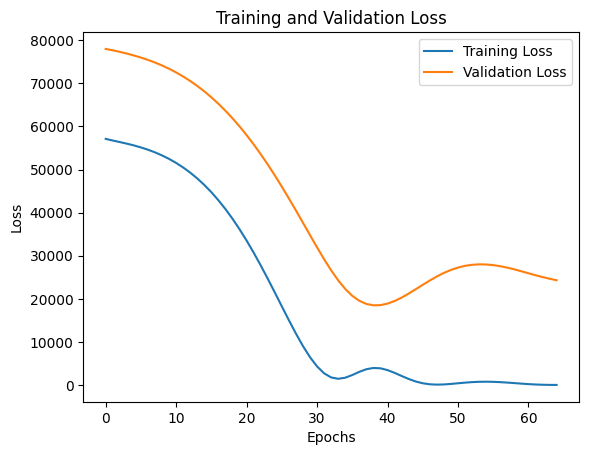

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Top users for game: [4 3]


In [28]:
if __name__ == '__main__':
    # Load and preprocess data
    data_loader = DataLoader('player_data.json')  # Replace with actual path
    df = data_loader.load_data()

    preprocessor = DataPreprocessor()
    df, num_users, num_games = preprocessor.preprocess(df)
    
    dataset_preparer = DatasetPreparer(batch_size=128)
    train_dataset, test_dataset = dataset_preparer.get_train_test_datasets(df)

    # Create model instances
    embedding_dim = 512
    siamese_model = SiameseRecommendationModel(num_users=num_users, num_games=num_games, embedding_dim=embedding_dim)
    vae_model = VAE(num_users=num_users, num_games=num_games, embedding_dim=embedding_dim)

    # Train the recommendation system
    recommender = RecommendationSystem(model=siamese_model, vae_model=vae_model)
    history = recommender.train_model(train_dataset, test_dataset)

    # Plot training and validation loss
    plot_loss(history)

    user_inputs, labels = dataset_preparer.create_input_tensors(df)
    # recommender.train_vae(user_inputs[0], labels)

    # Recommend top 3 users for a specific game
    game_id = 2
    user_id = 1
    top_users = recommender.recommend_top_users(df, game_id, user_id, num_recommendations=2)
    print("Top users for game:", top_users)